In [1]:
import yaml, glob, random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
from tqdm import tqdm
from skimage import exposure
from scipy import signal
mpl.rcParams['figure.dpi'] = 300
plt.rcParams["xtick.direction"] = 'in'
plt.rcParams["ytick.direction"] = 'in'
params = {
   'axes.labelsize': 12,
   'font.size': 12,
   'legend.fontsize': 10,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': [4, 4],
   'mathtext.fontset': 'stix',
   'font.family': 'STIXGeneral'
   }
plt.rcParams.update(params)

from radon import sino_to_slice, full_reconstruction

(181, 512, 512)


histogram matching: 100%|██████████| 181/181 [00:06<00:00, 26.24it/s]


-4.625 3.109375


vertical shift correction: 100%|██████████| 181/181 [00:00<00:00, 421.84it/s]


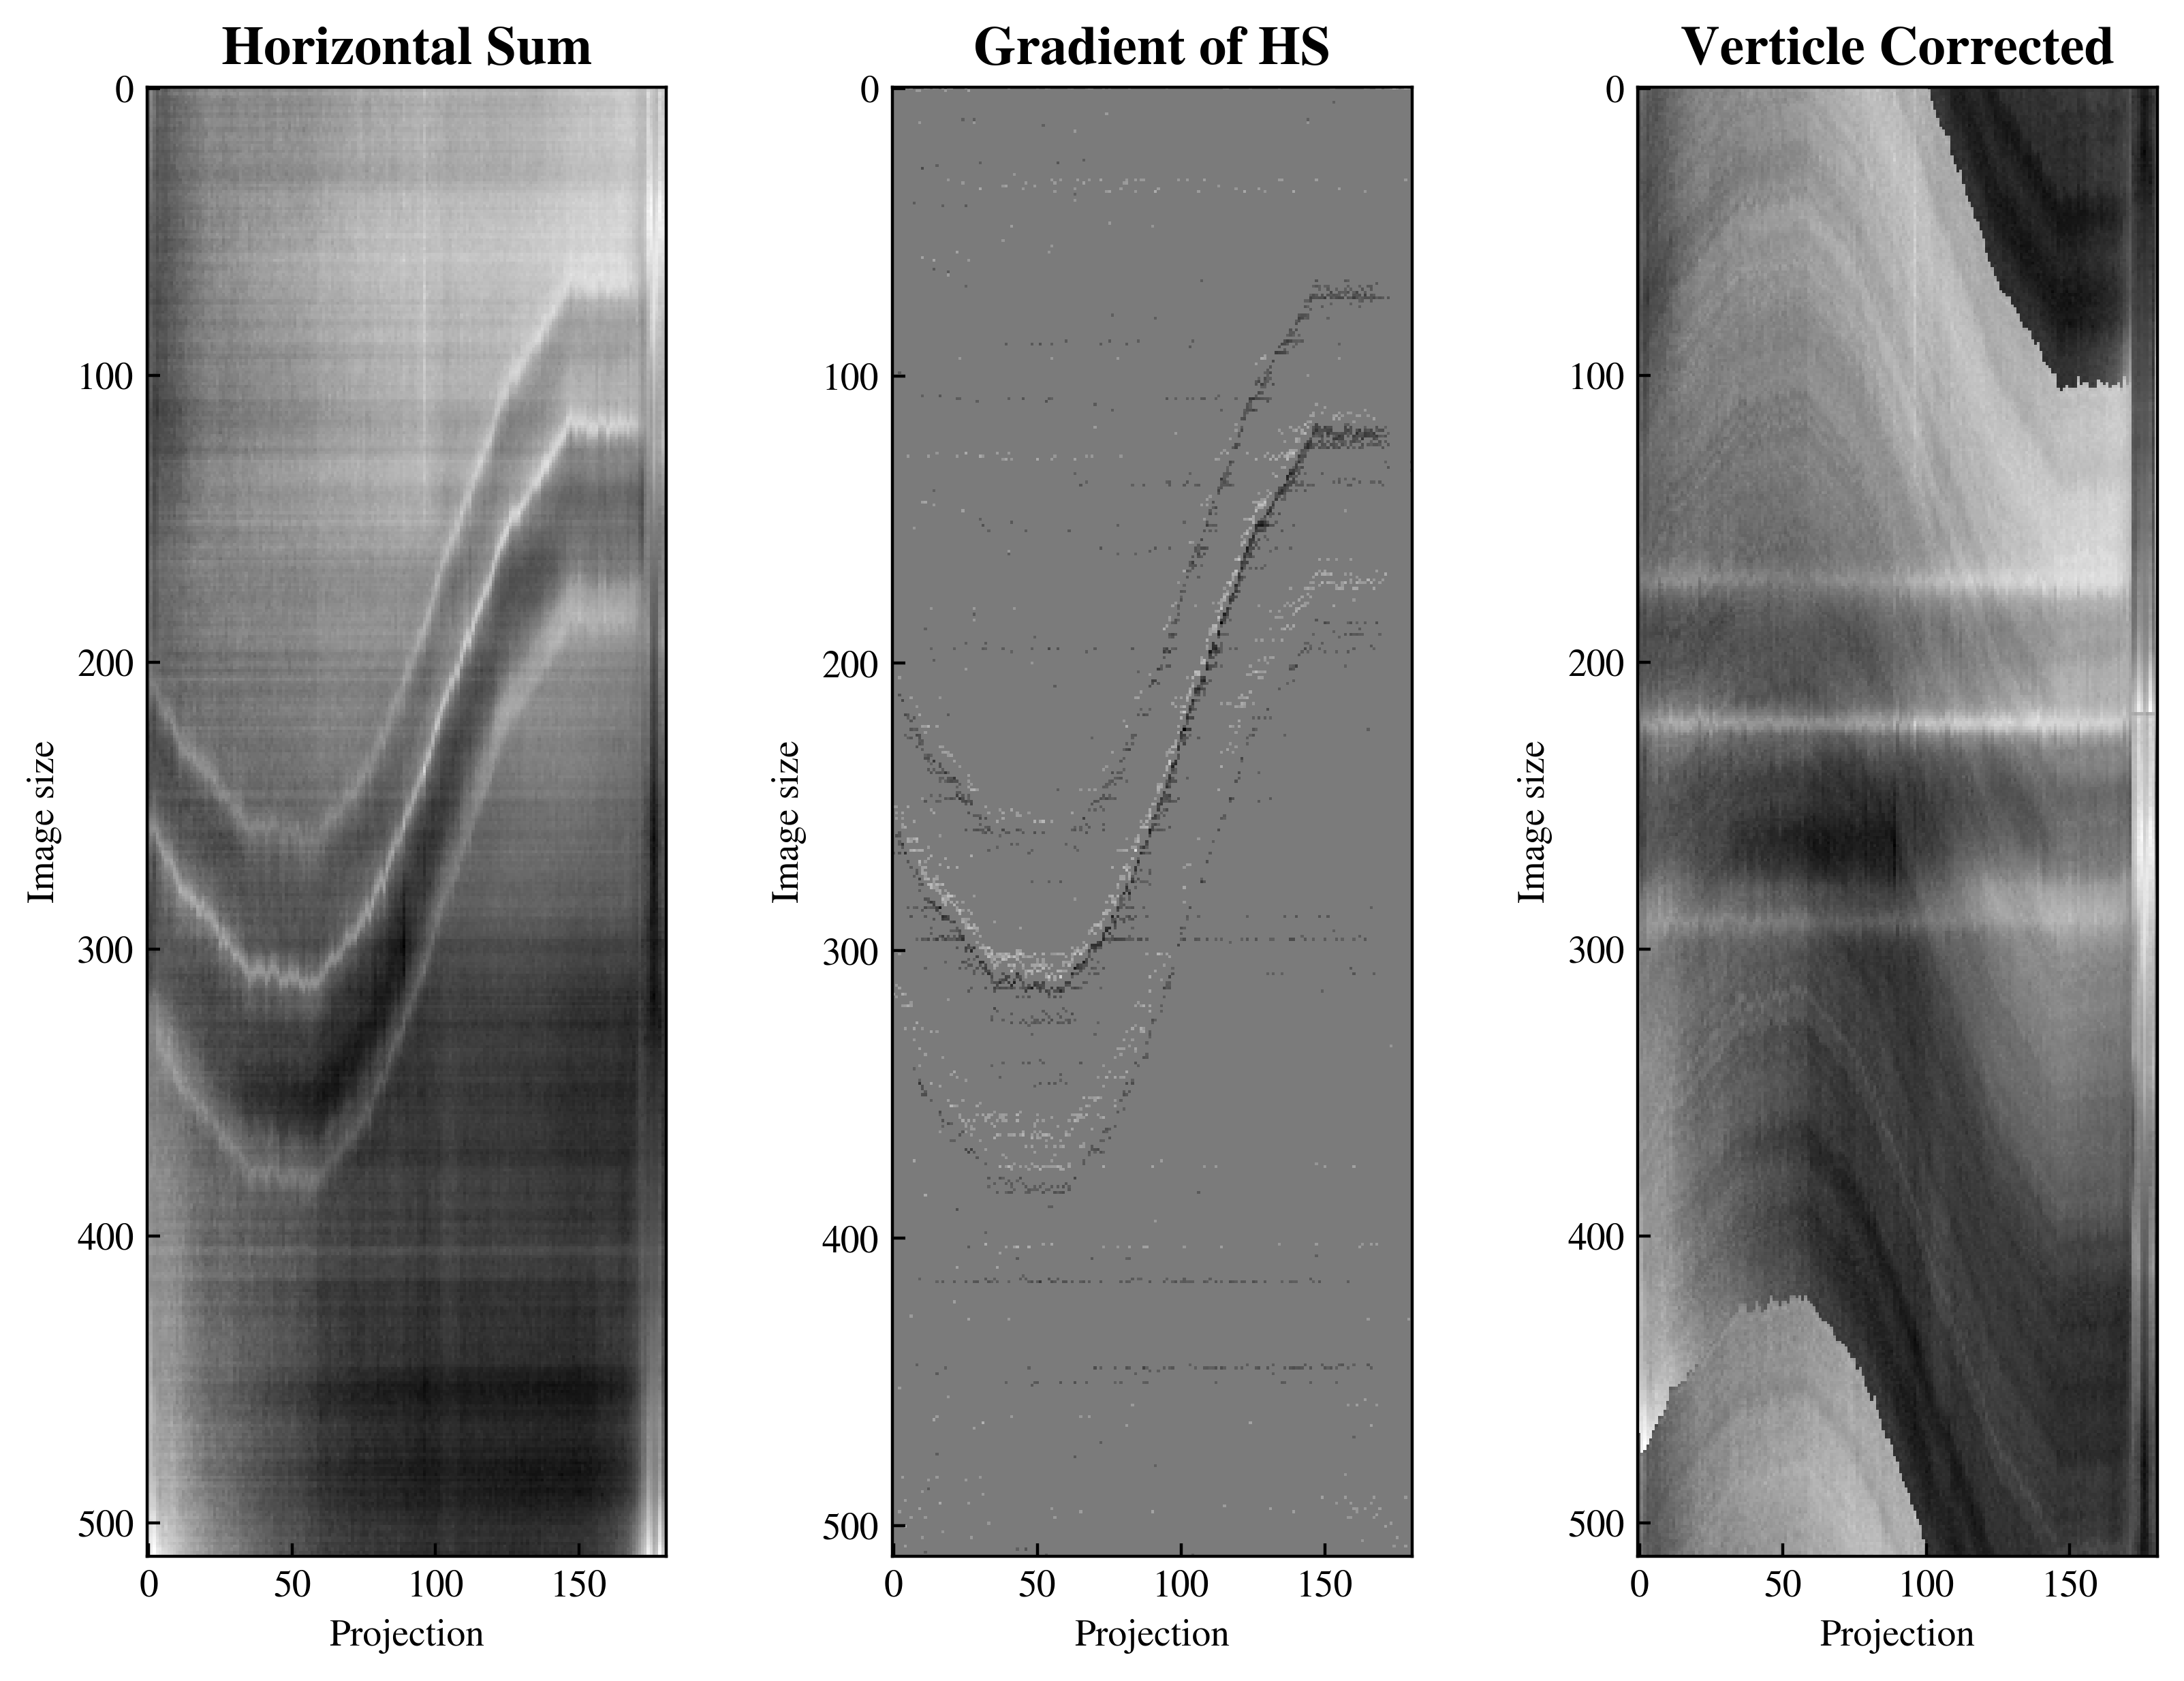

save image: 100%|██████████| 181/181 [00:00<00:00, 186.90it/s]


In [81]:
tomo_files = sorted(glob.glob('real_tomo/Au-b2-15s-181p-S15_raw/*tif'))

tomo = []
for f in tomo_files:
    img = Image.open(f)
    img = np.array(img)
    img = img - img.min()
    img = img / img.max()
    tomo.append(img)
tomo = np.array(tomo)
print(tomo.shape)

# normalize
ref_img = tomo[100]
for i, img in tqdm(enumerate(tomo), desc='histogram matching', total=len(tomo)):
    tomo[i] = exposure.match_histograms(img, ref_img, channel_axis=None)

# vertical alignment
ref_hs_grad = np.diff(signal.medfilt(np.sum(tomo[100], axis=1), 7))
bound = 1.7
ref_hs_grad[(ref_hs_grad<bound)&(ref_hs_grad>-bound)] = 0
print(ref_hs_grad.min(), ref_hs_grad.max())
tomo_v = []
grad = []
for i, im in tqdm(enumerate(tomo), desc='vertical shift correction', total=len(tomo)):
    im_hs_grad = np.diff(signal.medfilt(np.sum(im, axis=1), 7))
    im_hs_grad[(im_hs_grad<bound)&(im_hs_grad>-bound)] = 0
    v_shift_corr = np.correlate(ref_hs_grad, im_hs_grad, 'same')
    v_shift = np.argmax(v_shift_corr)
    im = np.roll(im, v_shift-256, axis=0)
    tomo_v.append(im)
    grad.append(im_hs_grad)
tomo_v = np.array(tomo_v)

fig, ax = plt.subplots(1, 3, figsize=(10, 7))
ax[0].imshow(np.sum(tomo, axis=2).T, cmap='gray')
ax[0].set_title('Horizontal Sum', weight='bold')
ax[1].imshow(np.array(grad).T, cmap='gray')
ax[1].set_title('Gradient of HS', weight='bold')
ax[2].imshow(np.sum(tomo_v, axis=2).T, cmap='gray')
ax[2].set_title('Verticle Corrected', weight='bold')
for i in range(3):
    ax[i].set_xlabel('Projection')
    ax[i].set_ylabel('Image size')
plt.show()

tomo_v = tomo_v - tomo_v.min()
tomo_v = tomo_v / tomo_v.max()
for i, im in tqdm(enumerate(tomo_v), desc='save image', total=len(tomo)):
    img = Image.fromarray((im*255).astype(np.uint8))
    img.save(f'real_tomo/Au-b2-15s-181p-S15-aligned_V/{i:04}.tif')


### Fourier Shell Correlation

In [2]:
def compute_frc(img1, img2, threshold=0.143, pixel_size=1.0):
    """
    計算兩張2D影像的FRC曲線並判斷解析度
    Parameters:
        img1, img2 : 2D numpy arrays
        threshold : FRC判定閾值 (默認0.143)
        pixel_size : 像素物理尺寸 (單位: Å/pixel)
    Returns:
        resolution : 估算解析度 (Å)
        frc_curve : FRC曲線
        freq_rings : 空間頻率 (1/Å)
    """
    # 1. FFT並中心化
    F1 = np.fft.fftshift(np.fft.fft2(img1))
    F2 = np.fft.fftshift(np.fft.fft2(img2))
    
    # 2. 計算每個像素到中心的距離
    shape = img1.shape
    center = np.array(shape) // 2
    y, x = np.indices(shape)
    radii = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    
    # 3. 分環參數
    max_radius = int(np.min(center))
    num_rings = max_radius
    ring_edges = np.arange(0, max_radius+1)
    freq_rings = ring_edges / (2 * max_radius * pixel_size)
    
    # 4. 計算每個環的FRC
    frc_curve = np.zeros(num_rings)
    for i in range(num_rings):
        mask = (radii >= ring_edges[i]) & (radii < ring_edges[i+1])
        F1_ring = F1[mask]
        F2_ring = F2[mask]
        
        numerator = np.sum(F1_ring * np.conj(F2_ring))
        denominator = np.sqrt(np.sum(np.abs(F1_ring)**2) * np.sum(np.abs(F2_ring)**2))
        frc_curve[i] = np.abs(numerator / denominator) if denominator != 0 else 0

    # 5. 解析度判定
    valid_indices = np.where(frc_curve > threshold)[0]
    if len(valid_indices) == 0:
        resolution = np.inf
    else:
        cutoff_ring = valid_indices[-1] + 1
        resolution = 1 / freq_rings[cutoff_ring] if cutoff_ring < len(freq_rings) else np.inf

    return resolution, frc_curve, freq_rings

def plot_frc(frc_curve1, frc_curve2, freq_rings1, freq_rings2, reso1, reso2, threshold=0.143):
    plt.figure(figsize=(5, 3))
    plt.plot(freq_rings1[1:], frc_curve1, c='tab:blue', ls='--', label='manual_aligned', alpha=0.5)
    plt.text(1/reso1, 0.31, f'{reso1:.2f} nm', weight='bold', c='tab:blue')
    plt.axvline(1/reso1, color='black', lw=0.5, ls='--')
    plt.plot(freq_rings2[1:], frc_curve2, 'b-', label='model_aligned', alpha=0.5)
    plt.text(1/reso2, 0.41, f'{reso2:.2f} nm', weight='bold', c='b')
    plt.axvline(1/reso2, color='black', lw=0.5, ls='--')
    plt.axhline(threshold, color='r', linestyle='--', label=f'Threshold ({threshold})', lw=1)
    plt.xlabel('Spatial Frequency (1/nm)')
    plt.ylabel('FRC')
    plt.ylim(0, 1.1)
    plt.legend()
    plt.show()

def tvloss(x):
    dh = np.abs(x[:-1, :] - x[1:, :])/255
    dw = np.abs(x[:, :-1] - x[:, 1:])/255
    # weight_h = np.exp(-dh)
    # weight_w = np.exp(-dw)
    # loss = (weight_h * dh**2).mean() + (weight_w * dw**2).mean()
    loss = (dh**2).mean()
    return loss

def symmetry_loss(img):
    flipped = np.flipud(img)  # horizontal flip
    return np.mean(np.abs(img - flipped))

def min_max_norm(img, percent=[0, 99.5], inverse=False):
    vmin = np.percentile(img, percent[0])
    vmax = np.percentile(img, percent[1])
    img = np.clip(img, vmin, vmax)
    img = (img - img.min()) / (img.max() - img.min())
    if inverse:
        img = 1 - img
    return img


### Generate Real Sinogram

In [3]:
save_sino = True

sample_name = 'tomo2-R1-D3-6-1-b4-40s-153p'
projections = []
tomo_files = sorted(glob.glob(f'real_tomo/{sample_name}/*tif'))

for i, f in enumerate(tomo_files):
    img = Image.open(f).resize((512, 512))
    img = np.array(img)
    projections.append(img)
projections = np.array(projections)
n_projs = len(projections)
# projections = np.roll(projections, shift=25, axis=2)

sino_temp = projections[:, 255]
sino_temp = sino_temp-sino_temp.min(axis=1)[:, None]
sino_temp = sino_temp/sino_temp.max(axis=1)[:, None]
sino_temp = 1-sino_temp

angles = np.linspace(0, np.pi*((n_projs-1)/180), n_projs)
recon = sino_to_slice(sino_temp, angles)
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[0].imshow(sino_temp, cmap='gray')
ax[1].imshow(recon, cmap='gray')
ax[1].axis('off')

if save_sino:
    for i in range(250, 340, 3):
        Image.fromarray(projections[:, i, :]).save(f'AI align/{sample_name}/{i+1:03}.tif')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

### Sinogram Alignment model

[ -2  -5 -10  -6  -8  -8  -6  -6  -5  -6  -5  -5  -5  -4  -5  -4  -4  -3
  -4  -4  -4  -4  -4  -4  -4  -4  -4  -4  -4  -3  -3  -2  -2  -2  -2  -2
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -2  -2  -2  -2  -2  -2  -2  -2  -3
  -2  -3  -2  -2  -3  -3  -3  -3  -3  -3  -3  -2  -3  -2  -2  -2  -2  -2
  -2  -2  -2  -3  -1  -2  -2  -2  -3  -2  -3  -4  -3  -3  -3  -3  -4  -3
  -3  -2  -3  -2  -2  -3  -2  -2  -2  -3  -4  -5  -4  -4  -5  -5  -4  -5
  -6  -5  -6  -6  -7  -7  -7  -6  -5  -5  -5  -4  -4  -5  -5  -5  -4  -4
  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -3  -2  -3  -3
  -3  -2  -3  -3  -2  -3  -3  -3  -3  -2  -3  -3  -2  -4  -5  -4  -4  -4
  -4  -4  -3  -4  -4  -4  -4  -4  -5  -7  -6  -9  -7  -6  -4  -5  -4  -7
  -7]


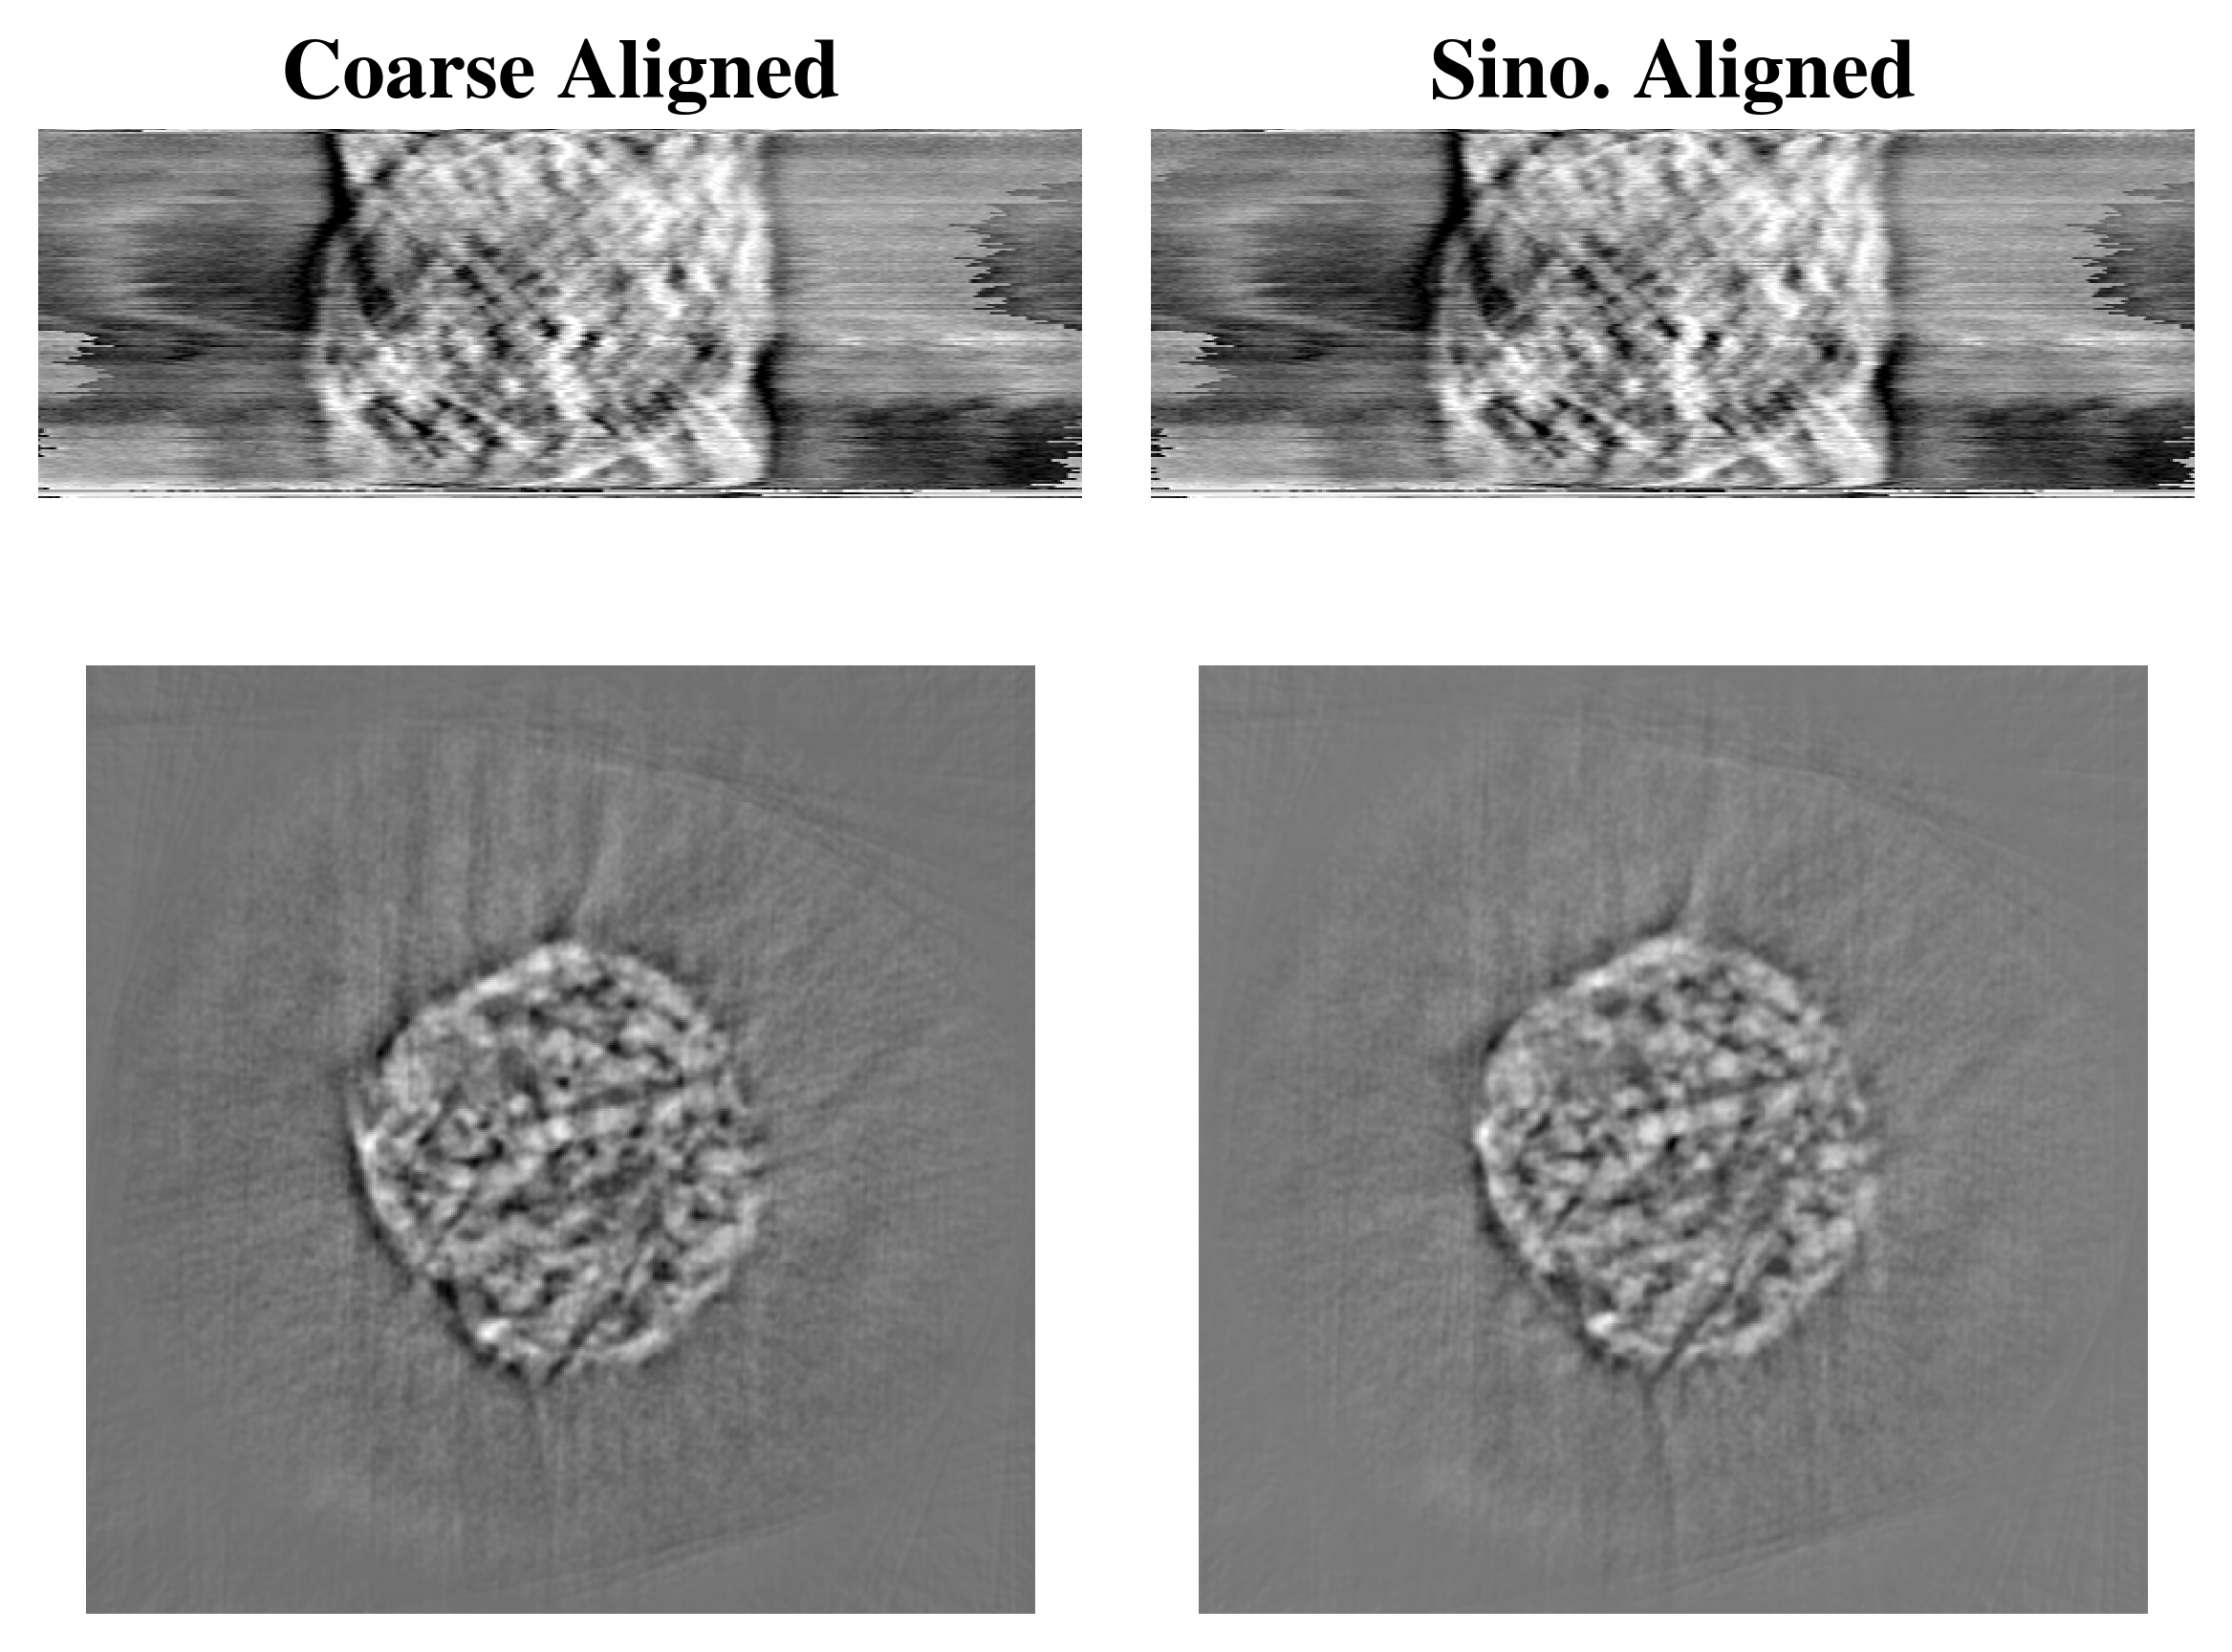

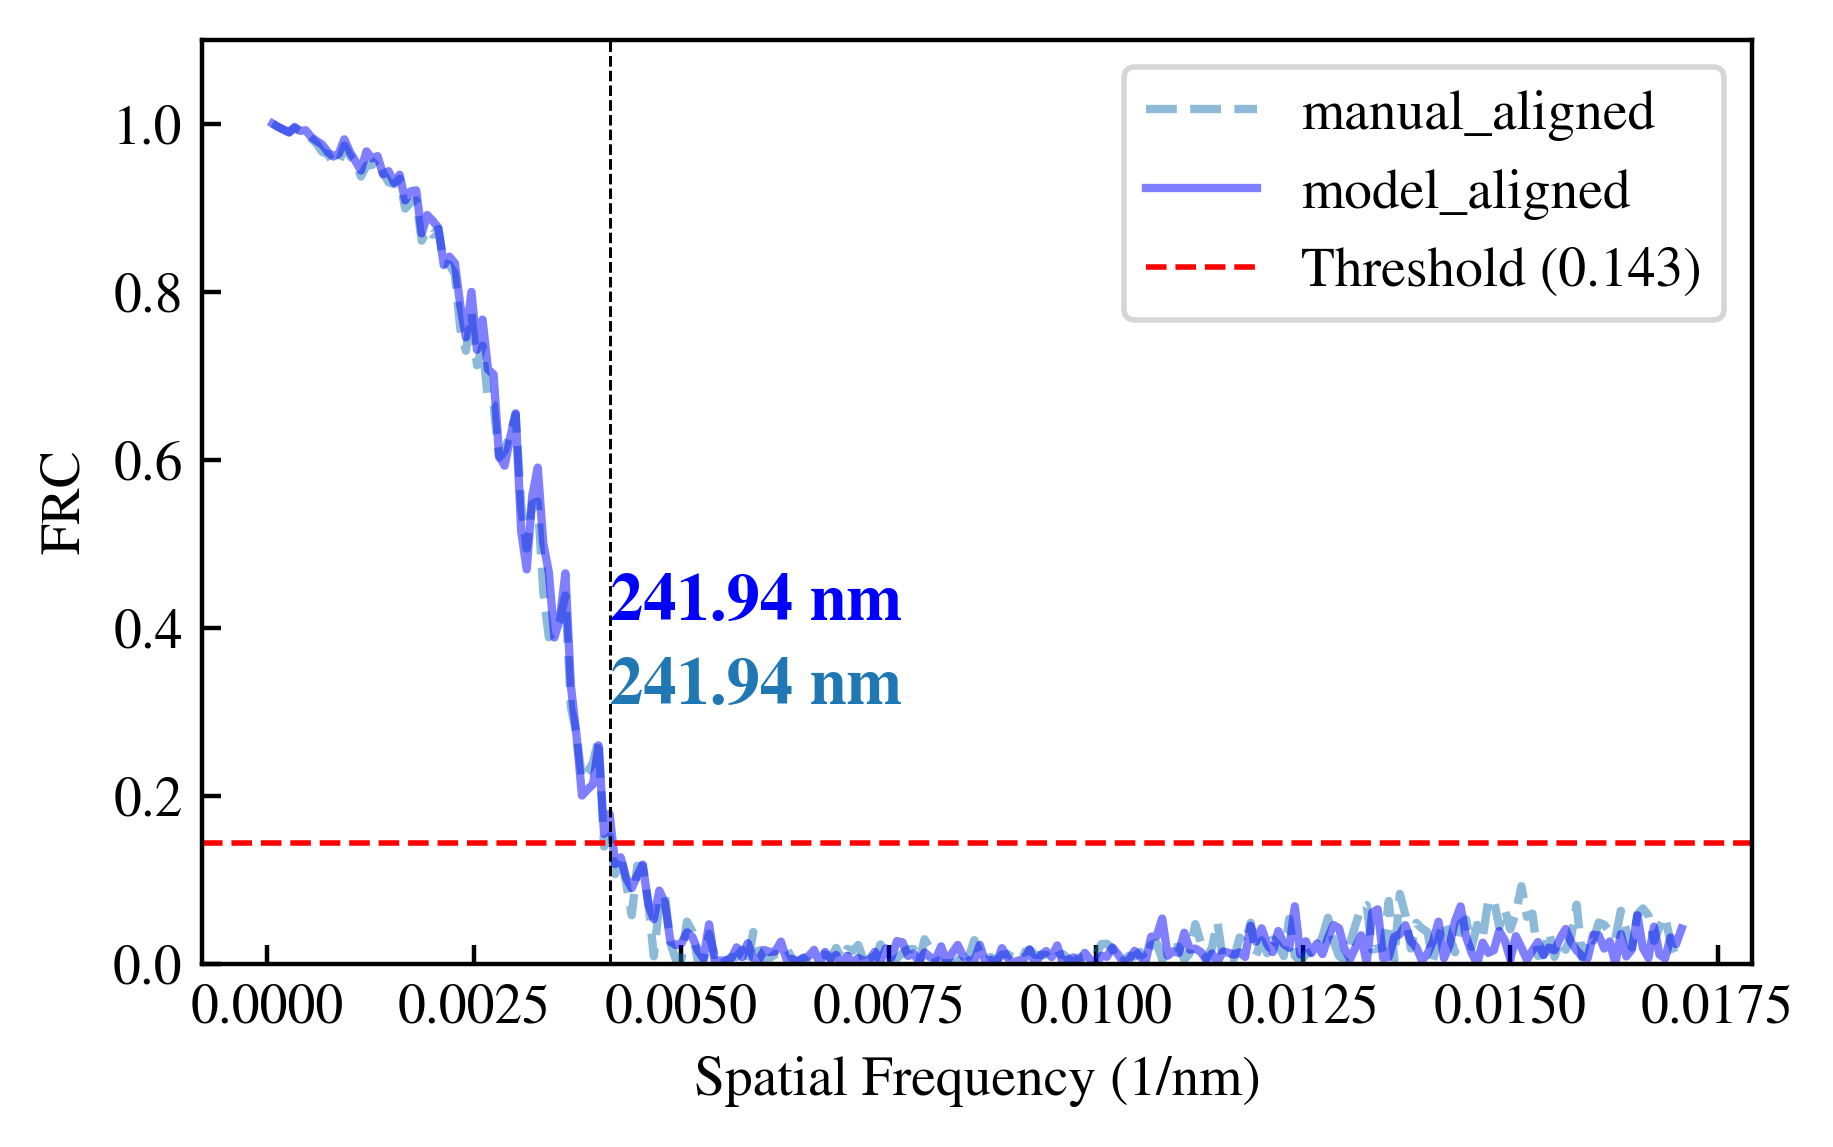

In [5]:
import torch
from model import Alignment_Net

torch.random.manual_seed(11)
save_recon = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
with open('configs/alignment_self_att_v3.yml', 'r') as f:
    configs = yaml.safe_load(f)

# load tomo datas
projections = []
tomo_files = sorted(glob.glob('../tomo_test/temp/*tif'))

for i, f in enumerate(tomo_files):
    img = Image.open(f).resize((512, 512))
    img = np.array(img)
    projections.append(img)
projections = np.array(projections)
n_projs = len(projections)

test_data = projections[:, 277].copy()
test_data = test_data-test_data.min(axis=1)[:, None]
test_data = test_data/test_data.max(axis=1)[:, None]
test_data = 1-test_data

if n_projs<181:
    temp = np.zeros((181, 512))
    temp[:n_projs] = test_data
    test_data = temp

# create key self-attention key padding mask for sparse angle
mask = torch.ones((1, 181), dtype=bool)
mask[:, :n_projs] = 0

model = Alignment_Net(configs['model_settings']).to(device)
model.load_state_dict(torch.load('checkpoints/alignment_RPE_MSErecon_ep600.pt', map_location=device), strict=False)
model.eval()

rnd_shift_list = []
test_orig = test_data.copy()
for i in range(len(test_data)):
    rnd_shift = random.randint(-25, 25)
    rnd_shift_list.append(-45)
    test_data[i, :] = np.roll(test_data[i, :], shift=-45)


new_sino = np.zeros(test_data.shape)
total_shift = []
with torch.no_grad():
    in_sino = test_data.copy()
    repeat = 1
    for r in range(repeat): 
        if r == 0:
            new_sino = in_sino.copy()
        sino = torch.from_numpy(new_sino).unsqueeze(0).float().to(device)
        shifts, aligned = model(sino, mask=mask.to(device))
        shifts, aligned = shifts.cpu().detach().squeeze().numpy(), aligned.cpu().detach().squeeze().numpy()
        pred_shift = np.round(shifts*50).astype(int)
        print(pred_shift)

        if r == 0:
            total_shift = -pred_shift 
        else:
            total_shift -= pred_shift

        for i in range(len(new_sino)):
            proj_temp = new_sino[i].copy()
            proj_temp = np.roll(proj_temp, -pred_shift[i])
            new_sino[i] = proj_temp

# plot ground truth
angles = np.linspace(0, np.pi*(180/180), 181)
fig, axs = plt.subplots(2, 2, figsize=(6, 5))

axs[0, 0].imshow(test_data[:n_projs], cmap='gray', interpolation='none')
axs[0, 0].set_title('Coarse Aligned', weight='bold', fontsize=16)
axs[0, 0].axis('off')

recon_raw = sino_to_slice(test_data, angles)
axs[1, 0].imshow(recon_raw, cmap='gray', interpolation='none')
axs[1, 0].axis('off')

axs[0, 1].imshow(new_sino[:n_projs], cmap='gray', interpolation='none')
axs[0, 1].set_title('Sino. Aligned', weight='bold', fontsize=16)
axs[0, 1].axis('off')

recon_new = sino_to_slice(new_sino, angles)
axs[1, 1].imshow(recon_new, cmap='gray', interpolation='none')
axs[1, 1].axis('off')

fig.tight_layout()
plt.show()
plt.close()

group1 = np.arange(90)*2
group2 = np.arange(89)*2+1
# group1 = np.random.choice([True, False], 181)
# group2 = ~group1

recon_raw_even = sino_to_slice(test_data[group1], angles[group1])
recon_raw_odd = sino_to_slice(test_data[group2], angles[group2])
resolution1, frc1, frequencies1 = compute_frc(recon_raw_even, recon_raw_odd, pixel_size=15000/512)

recon_new_even = sino_to_slice(new_sino[group1], angles[group1])
recon_new_odd = sino_to_slice(new_sino[group2], angles[group2])

resolution2, frc2, frequencies2 = compute_frc(recon_new_even, recon_new_odd, pixel_size=15000/512)
plot_frc(frc1, frc2, frequencies1, frequencies2, resolution1, resolution2)

if save_recon:
    n_proj = len(projections)
    # correct all tomo data
    for i in range(n_proj):
        proj_temp = projections[i].copy()
        proj_temp = np.roll(proj_temp, rnd_shift_list[i]+total_shift[i], axis=1)
        projections[i] = proj_temp

    for i, image in enumerate(projections):
        image = min_max_norm(image, percent=[0, 99.5], inverse=True)
        image = (image.squeeze()*255).astype(np.uint8)
        Image.fromarray(image).save(f'fig_temp/{i:03}.tif')

    

    angles = np.linspace(0, np.pi*(n_proj/180), n_proj)
    recon = full_reconstruction(projections, angles)
    recon = np.array(recon)
    recon = recon - recon.min()
    recon = recon / recon.max()
    recon = (recon*255).astype(np.uint8)
    recon = 255-recon
    for i in range(len(recon)):
        Image.fromarray(recon[i]).save(f'fig_temp/recon/{i:03}.tif')